In [3]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

%matplotlib inline

%cd ../..

!hostname

/p/fastdata/pli/Private/oberstrass1/datasets/vervet1818-3d
jrlogin03.jureca


In [4]:
import os

import re
import pandas as pd
import numpy as np

import h5py as h5

import pli
import pli.image as im

from tqdm import tqdm

In [5]:
# Get mask and feature info

model_name = "resnet50_planes8_962-1083_sphere_small"

cluster_path = f"data/aa/clusters/agglomerative_14/{model_name}"
feature_path = f"data/aa/pca_80/{model_name}"

# Group of the cluster in the H5 files
cluster_group = "Image"

# Group of the features in the H5 files
feature_group = "PCA"

###

p = re.compile('.*s([0-9]{4}).*h5')

feature_list = []
for f in sorted(os.listdir(feature_path)):
    match = p.match(f)
    if match:
        id = int(match[1])
        with h5.File(os.path.join(feature_path, f)) as h5f:
            spacing = h5f[feature_group].attrs['spacing']
            origin = h5f[feature_group].attrs['origin']
        feature_list.append({'id': id, 'spacing': spacing, 'origin': origin, 'file_features': os.path.join(feature_path, f)})
feature_df = pd.DataFrame(feature_list)

cluster_list = []
for f in sorted(os.listdir(cluster_path)):
    match = p.match(f)
    if match:
        id = int(match[1])
        cluster_list.append({'id': id, 'file_cluster': os.path.join(cluster_path, f)})
cluster_df = pd.DataFrame(cluster_list)

files_df = cluster_df.merge(feature_df, on='id', how='inner').sort_values('id').reset_index(drop=True)

files_df.head()

,id,file_cluster,spacing,origin,file_features
0,841,data/aa/clusters/agglomerative_14/resnet50_pla...,"[84.37760174274445, 84.37760174274445]","[0.0, 0.0]",data/aa/pca_80/resnet50_planes8_962-1083_spher...
1,842,data/aa/clusters/agglomerative_14/resnet50_pla...,"[84.37760174274445, 84.37760174274445]","[0.0, 0.0]",data/aa/pca_80/resnet50_planes8_962-1083_spher...
2,843,data/aa/clusters/agglomerative_14/resnet50_pla...,"[84.37760174274445, 84.37760174274445]","[0.0, 0.0]",data/aa/pca_80/resnet50_planes8_962-1083_spher...
3,844,data/aa/clusters/agglomerative_14/resnet50_pla...,"[84.37760174274445, 84.37760174274445]","[0.0, 0.0]",data/aa/pca_80/resnet50_planes8_962-1083_spher...
4,845,data/aa/clusters/agglomerative_14/resnet50_pla...,"[84.37760174274445, 84.37760174274445]","[0.0, 0.0]",data/aa/pca_80/resnet50_planes8_962-1083_spher...


In [6]:
target_file = "data/aa/volume/brain_visa/equivolumic_depth_6_fixed.nii.gz"

###

import nibabel as nib

target_nifti = nib.load(target_file)
target_spacing = tuple(np.diag(target_nifti.affine)[:3])
target_volume = np.array(target_nifti.dataobj)[:, ::-1, ::-1]

target_volume.shape

(448, 243, 485)

In [19]:
# Load all PCA sections

background_cluster = 0

# Smoothing of the features
sigma = 1.0

###

from skimage import filters
from vervet1818_3d.utils.io import read_masked_features

selected_target = []
selected_features = []
selected_clusters = []

for i, (k, r) in tqdm(enumerate(files_df.sort_values('id').iterrows()), total=len(files_df)):
    features, cluster = read_masked_features(
        r.file_features,
        r.file_cluster,
        mask_pyramid=0,
        data_group=feature_group,
        mask_group=cluster_group
    )
    assert features.shape[:2] == cluster.shape, f"{features.shape[:2]} differs from {cluster.shape}"

    # Smooth features a bit
    if sigma > 0.:
        features = filters.gaussian(features, multichannel=True, sigma=sigma)

    selected_target.append(target_volume[:, i, :])
    selected_features.append(features)
    selected_clusters.append(cluster)

valid_target = [f[m != background_cluster] for f, m in zip(selected_target, selected_clusters)]
valid_clusters = [m[m != background_cluster] for f, m in zip(selected_features, selected_clusters)]
valid_features = [f[m != background_cluster] for f, m in zip(selected_features, selected_clusters)]

valid_lengths = [len(vf) for vf in valid_features]

valid_target = np.concatenate(valid_target)
valid_features = np.vstack(valid_features)
valid_clusters = np.concatenate(valid_clusters)

print(f"Valid features have shape {valid_features.shape} and clusters {valid_clusters.shape}")

100%|██████████| 116/116 [00:08<00:00, 14.47it/s]


Valid features have shape (9171147, 20) and clusters (9171147,)


In [8]:
n_subfeatures = 4_000
seed = 299792458

###

np.random.seed(seed)

# Reduce to the selected valid components
ix = np.random.choice(np.arange(len(valid_features)), n_subfeatures)

selected_features = valid_features[ix]
selected_clusters = valid_clusters[ix]
selected_target = valid_target[ix]

In [9]:
# Umap reduction

import umap

reducer = umap.UMAP(random_state=299_792_458)

embedding = reducer.fit_transform(selected_features)

/p/project/cjinm11/Private/oberstrass1/git/envs/pli-env/venv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


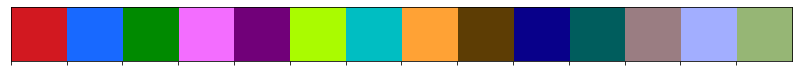

In [13]:
n_cluster = 14

###

import glasbey
import seaborn as sns

color_palette = glasbey.create_palette(palette_size=n_cluster)

sns.palplot(color_palette)

In [14]:
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.family'] = 'sans-serif'

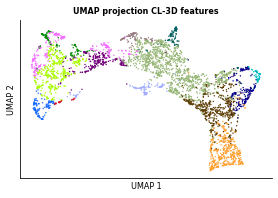

In [15]:
from matplotlib.ticker import MultipleLocator

# Create a figure and axis
fig, ax = plt.subplots(figsize=(3.914, 2.793))

ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[color_palette[x - 1] for x in selected_clusters],
    s=8.,
    marker='.',
    alpha=1.0,
    edgecolors='none',
)
ax.set_aspect('equal')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the x-axis tick interval to 2
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))

plt.xticks([], [])
plt.yticks([], [])

# Set the x-axis title
ax.set_xlabel("UMAP 1")

# Set the y-axis title
ax.set_ylabel("UMAP 2")

ax.set_title('UMAP projection CL-3D features')

plt.tight_layout()
# Save the figure
#plt.savefig("doc/umap/sphere_small_umap.png", dpi=500)
#plt.savefig("doc/umap/sphere_small_umap.svg")


In [20]:
valid_target.max()

1.0

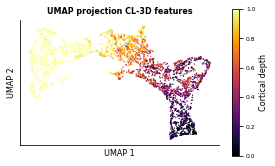

In [39]:
from matplotlib.ticker import MultipleLocator

# Create a figure and axis
fig, ax = plt.subplots(figsize=(3.914, 2.793))

sc = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=selected_target,
    cmap='inferno',
    s=8.,
    marker='.',
    alpha=1.0,
    edgecolors='none',
)
ax.set_aspect('equal')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the x-axis tick interval to 2
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))

plt.xticks([], [])
plt.yticks([], [])

# Set the x-axis title
ax.set_xlabel("UMAP 1")

# Set the y-axis title
ax.set_ylabel("UMAP 2")

ax.set_title('UMAP projection CL-3D features')

plt.colorbar(sc, label="Cortical depth", shrink=0.8)

plt.tight_layout()
# Save the figure
plt.savefig("doc/umap/sphere_small_umap_depth.png", dpi=500)
plt.savefig("doc/umap/sphere_small_umap_depth.svg")


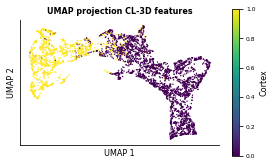

In [44]:
from matplotlib.ticker import MultipleLocator

# Create a figure and axis
fig, ax = plt.subplots(figsize=(3.914, 2.793))

sc = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=selected_target >= 0.999,
    # cmap='inferno',
    s=8.,
    marker='.',
    alpha=1.0,
    edgecolors='none',
)
ax.set_aspect('equal')

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the x-axis tick interval to 2
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))

plt.xticks([], [])
plt.yticks([], [])

# Set the x-axis title
ax.set_xlabel("UMAP 1")

# Set the y-axis title
ax.set_ylabel("UMAP 2")

ax.set_title('UMAP projection CL-3D features')

plt.colorbar(sc, label="Cortex", shrink=0.8)

plt.tight_layout()
# Save the figure
plt.savefig("doc/umap/sphere_small_umap_cortex.png", dpi=500)
plt.savefig("doc/umap/sphere_small_umap_cortex.svg")
